<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_11_Project_2_Option_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Heart Disease Prediction

In this project we will retreive the heart disease dataset from UCI database, process it and use DL model to classify patients into those who get and dont get heart disease. The outcome will be binarized. THis is Mike's version

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## Numerical Analysis
import numpy as np
import scipy.stats as stats

## Dataset Management
import pandas as pd
import scipy.stats as stats

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## High-Quality Figures
from IPython import display
display.set_matplotlib_formats("svg")

In [2]:
# Download the data from original database
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

data = pd.read_csv(url, sep = ",", header=None)

data.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'disease']

data = data.replace("?", np.nan).dropna()

data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [3]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,disease
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000


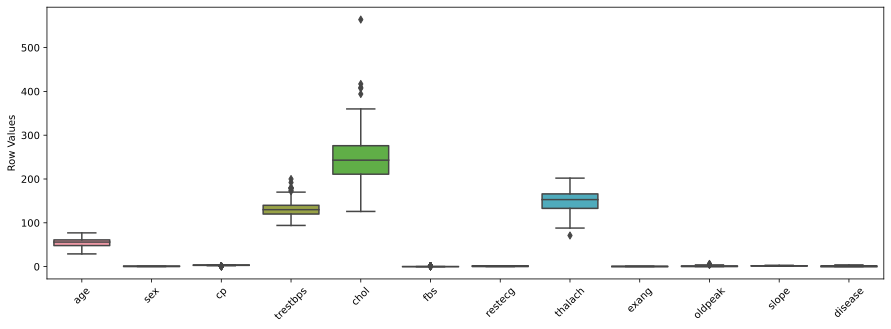

In [4]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax = sns.boxplot(data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Row Values")
plt.show()

In [5]:
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop(["sex", "fbs", "exang", "disease"])
print(cols2zscore)

Index(['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak',
       'slope', 'ca', 'thal'],
      dtype='object')


In [6]:
# Force some values to be numeric, otherwise it will not work downstream
for c in cols2zscore:
    d = pd.to_numeric(data[c])
    data[c] = (d - d.mean())/d.std(ddof=1)

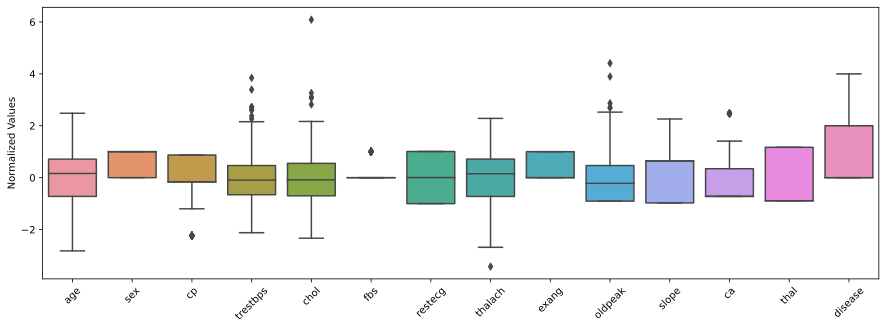

In [7]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax = sns.boxplot(data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Normalized Values")
plt.show()

In [8]:
data["disease"].value_counts()

0    160
1     54
2     35
3     35
4     13
Name: disease, dtype: int64

In [9]:
# Binarize the outcome
data["disease"][data["disease"] > 0] = 1
data.head()

<ipython-input-9-f52f1544d40f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["disease"][data["disease"] > 0] = 1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,0.934603,1.0,-2.236854,0.749116,-0.275978,1.0,1.008496,0.017465,0.0,1.067164,2.260330,-0.720760,0.654772,0
1,1.376605,1.0,0.872408,1.593577,0.743301,0.0,1.008496,-1.813274,1.0,0.381130,0.642696,2.474249,-0.892713,1
2,1.376605,1.0,0.872408,-0.658320,-0.352904,0.0,1.008496,-0.897904,1.0,1.324427,0.642696,1.409246,1.170601,1
3,-1.938409,1.0,-0.164013,-0.095345,0.050961,0.0,-1.001728,1.630258,0.0,2.096215,2.260330,-0.720760,-0.892713,0
4,-1.496407,0.0,-1.200433,-0.095345,-0.833696,0.0,1.008496,0.976423,0.0,0.295376,-0.974938,-0.720760,-0.892713,0


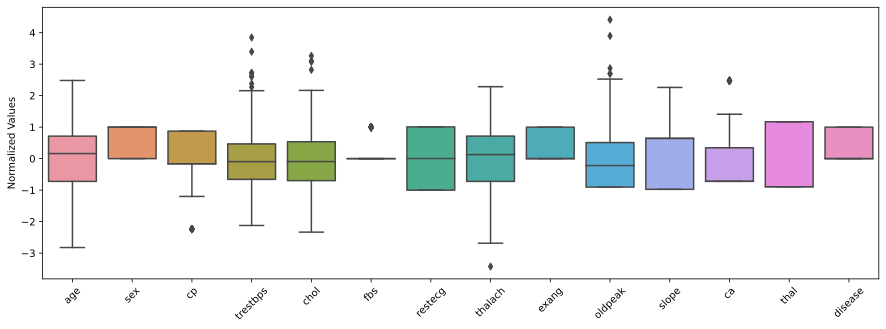

In [10]:
# Remove the cholesterol outlier
data = data[data["chol"] < 4]
fig, ax = plt.subplots(1, figsize=(15,5))
ax = sns.boxplot(data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Normalized Values")
plt.show()

### Reorganize the data and split it for training the model

In [11]:
# Convert the data into tensors
dataT = torch.tensor(data[data.keys().drop("disease")].values).float()
labels = torch.tensor(data["disease"].values).float()

print(dataT.shape)
print(labels.shape)

# We need the labels to be tensor
labels = labels[:,None]
print(labels.shape)

torch.Size([296, 13])
torch.Size([296])
torch.Size([296, 1])


In [12]:
# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size = 50)

# Convert to Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate to dataloader objects
batchsize = 20
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [13]:
for X,y in train_loader:
    print(X.shape, y.shape)

torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])
torch.Size([20, 13]) torch.Size([20, 1])


### Create a class for the DL model

In [14]:
class theNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(13, 32)

        # two hidden layers
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 10)

        # Output Layer
        self.output = nn.Linear(10, 1)

    # Define forward pass function
    def forward(self, x):
        
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [15]:
# test the model to check whether it works
net = theNet()

X,y = next(iter(train_loader))
yHat = net(X)
print(yHat)

tensor([[-0.3195],
        [-0.3084],
        [-0.3436],
        [-0.3639],
        [-0.2806],
        [-0.3689],
        [-0.3038],
        [-0.2753],
        [-0.3402],
        [-0.2494],
        [-0.3172],
        [-0.3481],
        [-0.2949],
        [-0.3056],
        [-0.2876],
        [-0.3011],
        [-0.3915],
        [-0.3677],
        [-0.3160],
        [-0.2506]], grad_fn=<AddmmBackward0>)


In [16]:
# Test the loss function
lossfun = nn.BCEWithLogitsLoss()
lossfun(yHat,y)

tensor(0.6721, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

### Train the Model

In [17]:
net = theNet()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
lossfun = nn.BCEWithLogitsLoss()

# Number of trianing epochs
numepochs = 100

# Initialize losses and accuracies
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

# Start the training
for epochi in range(numepochs):

    # Loop over training the data batches
    batchLoss = []

    for X,y in train_loader:

        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, y)

        # BackProp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Loss from each batch
        batchLoss.append(loss.item())

        # Train Accuracy
        predictions = (torch.sigmoid(yHat) > 0.5).float()
        trainAcc[epochi] = 100*torch.mean((predictions==y).float())
    # End of a batch

    # Average lossed and accuracy for batch
    trainLoss[epochi] = np.mean(batchLoss)

    # Test
    X,y = next(iter(test_loader))
    yHat = net(X)

    # test Losses
    loss = lossfun(yHat, y)
    testLoss[epochi] = loss.item()

    # Test Accuracy
    predictions = (torch.sigmoid(yHat) > 0.5).float()
    testAcc[epochi] = 100*torch.mean((predictions==y).float())

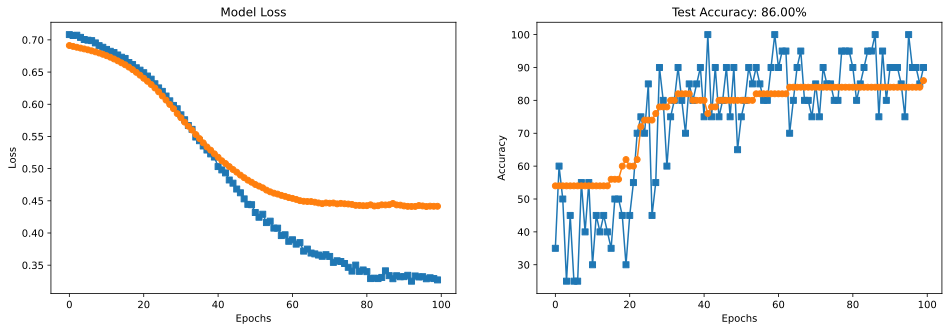

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

ax[0].plot(trainLoss, "s-", label="Train")
ax[0].plot(testLoss, "o-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model Loss")

ax[1].plot(trainAcc, "s-", label="Train")
ax[1].plot(testAcc, "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title(f"Test Accuracy: {testAcc[-1]:.2f}%")

plt.show()